In [33]:
from OMPython import OMCSessionZMQ
import os
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
output_demo = 'generate/'
file_demo = 'ModelDummy.mo'

# Introduction

#### Aim

Describe how to generate a dataset of modelica models with Python. 

#### General procedure

1. Create an instance of `OMCSessionZMQ`
1. Load the modelica file with `loadFile`
1. Build the model with `simulate`
1. Loop over the parameters
    1. Run the executable created in step 3, provide the argument `-override=param1_name=param1_value,param2_name=param2_value,...`

#### Get ready

In [5]:
if not os.path.isdir(output_demo):
    !mkdir $output_demo # create the directory for the demo

# Demo

## Model

We will use the following simple model for the demo:

In [15]:
!cat $file_demo

model Dummy
  Real x(start=1);
  parameter Real a = -1;
equation 
  der(x) = a*x;
end Dummy;


## Implementation

### Run the session & load file

In [7]:
# Instanciate the session
omc = OMCSessionZMQ()

2020-04-02 16:00:53,916 - OMPython - INFO - OMC Server is up and running at file:////tmp/openmodelica.maousi.port.e4ba25db899948578074ff6e82aed2df pid=13504


In [8]:
# Define utility function
def runcmd(cmd):
    return omc.sendExpression(cmd)

In [9]:
runcmd('getVersion()')

'OpenModelica 1.14.1'

In [16]:
# Load the model
runcmd('loadFile("{}")'.format(file_demo))

True

### Build the model

We use `simulate` to build the model and **generate an executable**. This is the right time to set all parameters that will not vary during the simulation loop (e.g. simulation time).

In [19]:
runcmd("simulate(Dummy, outputFormat=\"csv\")")

{'resultFile': '/media/maousi/Data/Documents/Programmation/git/vad-0d-dnn/test/Dummy_res.csv',
 'simulationOptions': "startTime = 0.0, stopTime = 1.0, numberOfIntervals = 500, tolerance = 1e-06, method = 'dassl', fileNamePrefix = 'Dummy', options = '', outputFormat = 'csv', variableFilter = '.*', cflags = '', simflags = ''",
 'messages': 'LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.\nLOG_SUCCESS       | info    | The simulation finished successfully.\n',
 'timeFrontend': 0.014158308,
 'timeBackend': 0.001866769,
 'timeSimCode': 0.000540843,
 'timeTemplates': 0.005058718,
 'timeCompile': 0.672368227,
 'timeSimulation': 0.050001659,
 'timeTotal': 0.744352939}

In [20]:
!ls

Dummy	       Dummy_08bnd.c  Dummy_14lnz.c	 Dummy_init.xml
Dummy_01exo.c  Dummy_08bnd.o  Dummy_14lnz.o	 Dummy.libs
Dummy_01exo.o  Dummy_09alg.c  Dummy_15syn.c	 Dummy_literals.h
Dummy_02nls.c  Dummy_09alg.o  Dummy_15syn.o	 Dummy.log
Dummy_02nls.o  Dummy_10asr.c  Dummy_16dae.c	 Dummy.makefile
Dummy_03lsy.c  Dummy_10asr.o  Dummy_16dae.h	 Dummy_model.h
Dummy_03lsy.o  Dummy_11mix.c  Dummy_16dae.o	 Dummy.o
Dummy_04set.c  Dummy_11mix.h  Dummy_17inl.c	 Dummy_records.c
Dummy_04set.o  Dummy_11mix.o  Dummy_17inl.o	 Dummy_records.o
Dummy_05evt.c  Dummy_12jac.c  Dummy.c		 Dummy_res.csv
Dummy_05evt.o  Dummy_12jac.h  Dummy_functions.c  generate
Dummy_06inz.c  Dummy_12jac.o  Dummy_functions.h  Howto-Dataset-generation.ipynb
Dummy_06inz.o  Dummy_13opt.c  Dummy_functions.o  ModelDummy.mo
Dummy_07dly.c  Dummy_13opt.h  Dummy_includes.h
Dummy_07dly.o  Dummy_13opt.o  Dummy_info.json


The first file in the list, i.e. `Dummy`, is the executable (it always has the name of the model in the `.mo` file).

### Simulation loop & parameter overriding

We take advantage of the fact that OpenModelica does *not* need to recompile the model in order to re-simulate a model with different parameters. We can simply run the executable that resulted from compilation. The easiest way to do this in Python is by using `os.system('./executable_name')`. We can tell modelica to modify specific parameters by providing the `-override` argument.

An easy way to perform the simulation loop is to create a *template command* that we modify accordingly in each simulation step with `format`.

In [21]:
# Define different parameters for the simulation
a = [-1, -0.5, 0.5, 1]

In [28]:
# Create the command that we will run with os.system
cmd_template = './Dummy' # executable name
cmd_template += ' -override=a={}' # parameter overriding
cmd_template += ' -r=' + output_demo + 'Dummy_output_{}.csv' # output file
cmd_template

'./Dummy -override=a={} -r=generate/Dummy_output_{}.csv'

In [29]:
# Simulation loop
for i, val in enumerate(a):
    # Replace the arguments accordingly
    cmd = cmd_template.format(val, i)
    # Run
    os.system(cmd)
    print(cmd)

./Dummy -override=a=-1 -r=generate/Dummy_output_0.csv
./Dummy -override=a=-0.5 -r=generate/Dummy_output_1.csv
./Dummy -override=a=0.5 -r=generate/Dummy_output_2.csv
./Dummy -override=a=1 -r=generate/Dummy_output_3.csv


### Results



In [31]:
!ls $output_demo

Dummy_output_0.csv  Dummy_output_1.csv	Dummy_output_2.csv  Dummy_output_3.csv


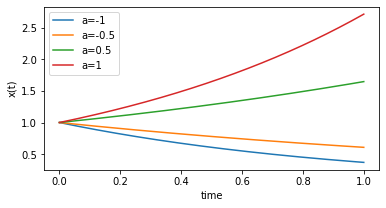

In [43]:
plt.figure(figsize=(6,3))
for i,val in enumerate(a):
    df = pd.read_csv(output_demo + 'Dummy_output_{}.csv'.format(i))
    plt.plot(df.time, df.x, label='a='+str(val))
plt.legend(); plt.xlabel("time"); plt.ylabel("x(t)");

We clearly see that the equation $\frac{dx}{dt} = ax$ was solved with different values of a.